# Random Forest Hyperparameter Analysis Framework

This notebook provides a comprehensive framework for analyzing the impact of various Random Forest hyperparameters on model performance. The analysis explores:

1. **Tree Depth Impact**: From minimal trees (underfitting) to deep trees (overfitting)
2. **Feature Selection Impact**: Number of randomly selected features for splits
3. **Interaction Effects**: Combined impact of depth and feature selection
4. **Dataset Complexity**: Analysis across multiple datasets of varying complexity

## Framework Structure:
- **Section 1**: Data Loading and Preprocessing
- **Section 2**: Random Forest Implementation and Utilities
- **Section 3**: Experiment 1 - Tree Depth Analysis
- **Section 4**: Experiment 2 - Feature Selection Analysis  
- **Section 5**: Experiment 3 - Interaction Analysis
- **Section 6**: Results Visualization and Analysis
- **Section 7**: Conclusions and Discussion

In [19]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, load_breast_cancer, load_wine
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [20]:
plt.rcParams['axes.labelsize'] = 20  # Axis label font size (IEEE double column)
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelpad'] = 12
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Times', 'TeX Gyre Termes', 'Nimbus Roman No9 L', 'DejaVu Serif']
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{newtxtext}\usepackage{newtxmath}'
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42 
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams.update(plt.rcParams)


## Section 1: Data Loading and Preprocessing

We'll work with three datasets of varying complexity:
1. **Simple Dataset**: Synthetic data with clear decision boundaries
2. **Medium Dataset**: Wine classification (moderate complexity)
3. **Complex Dataset**: Breast cancer classification

In [21]:
class DatasetManager:
    """Manages multiple datasets for Random Forest analysis"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.datasets = {}
        
    def load_datasets(self):
        """Load and prepare all datasets"""
        
        # 1. Simple Dataset: Synthetic with clear decision boundaries
        print("\n" + "=" * 80)
        print("DATASET 1: SIMPLE - Limited Overfitting Potential")
        print("=" * 80)
        X_simple, y_simple = make_classification(
            n_samples=500,         # Small dataset
            n_features=10,         # Few features
            n_informative=8,       # Most are informative
            n_redundant=2,
            n_classes=2,           # Binary classification (easier)
            class_sep=2.0,         # High separation - easy to classify
            flip_y=0.0,            # No noise - pure leaves possible
            random_state=42
        )
        print(f"Dataset: {X_simple.shape[0]} samples, {X_simple.shape[1]} features, 2 classes")
        print("Expected: Trees will stop growing early (~depth 10-15)")
        print("          Increasing max_depth won't increase overfitting\n")
        
        self.depth_range_simple = [1, 2, 3, 4, 5, 6, 8, 10, 12, None]
        self.datasets['simple'] = {
            'name': 'simple',
            'X': X_simple,
            'y': y_simple
        }
        # ========================================================================
        # DATASET 2: MEDIUM - Moderate overfitting potential
        # ========================================================================
        print("\n\n" + "=" * 80)
        print("DATASET 2: MEDIUM - Moderate Overfitting Potential")
        print("=" * 80)
        X_medium, y_medium = make_classification(
            n_samples=2000,        # Medium dataset
            n_features=25,         # Moderate features
            n_informative=18,
            n_redundant=5,
            n_classes=3,           # 3 classes
            class_sep=1.0,         # Medium separation
            flip_y=0.2,           # Small amount of noise
            random_state=42
        )
        print(f"Dataset: {X_medium.shape[0]} samples, {X_medium.shape[1]} features, 3 classes")
        print("Expected: Trees will grow to medium depths (~20-40)")
        print("          Some progressive overfitting visible\n")

        self.depth_range_medium = [1, 3, 5, 7, 10, 12, 15, 18, 20, 25, 30, None]
        self.datasets['medium'] = {
            'name': 'medium',
            'X': X_medium,
            'y': y_medium
        }
        


        # ========================================================================
        # DATASET 3: COMPLEX - Strong progressive overfitting
        # ========================================================================
        print("\n\n" + "=" * 80)
        print("DATASET 3: COMPLEX - Strong Progressive Overfitting")
        print("=" * 80)
        X_complex, y_complex = make_classification(
            n_samples=6000,        # Large dataset - more room to split
            n_features=50,         # Many features - more split options
            n_informative=35,      # Most features are informative
            n_redundant=10,        # Some redundancy
            n_classes=4,           # Multi-class makes it harder
            class_sep=0.7,         # Low separation - harder to split cleanly
            flip_y=0.3,           # 3% label noise - prevents pure leaves
            random_state=42
        )
        print(f"Dataset: {X_complex.shape[0]} samples, {X_complex.shape[1]} features, 4 classes")
        print("Expected: Trees will keep growing with higher max_depth")
        print("          Clear progressive overfitting from depth 100 to 120\n")

        self.depth_range_complex = [1, 3, 5, 7, 10, 12, 15, 20, 25, 30, 35, 40, None]
        self.datasets['complex'] = {
            'name': 'complex',
            'X': X_complex,
            'y': y_complex
        }
        
    def get_dataset_info(self):
        """Display information about all datasets"""
        for key, data in self.datasets.items():
            print(f"\n{data['name']}")
            print(f"  Features: {data['X'].shape[1]}")
            print(f"  Samples: {data['X'].shape[0]}")
            print(f"  Classes: {len(np.unique(data['y']))}")
            print(f"  Class distribution: {np.bincount(data['y'])}")
    
    def split_datasets(self, test_size=0.3):
        """Split all datasets into train/test sets"""
        self.splits = {}
        for key, data in self.datasets.items():
            X_train, X_test, y_train, y_test = train_test_split(
                data['X'], data['y'], 
                test_size=test_size, 
                random_state=self.random_state,
                stratify=data['y']
            )
            self.splits[key] = {
                'X_train': X_train, 'X_test': X_test,
                'y_train': y_train, 'y_test': y_test
            }
        print(f"Split {len(self.datasets)} datasets into train/test sets.")

# Initialize and load datasets
dataset_manager = DatasetManager(RANDOM_STATE)
dataset_manager.load_datasets()
dataset_manager.get_dataset_info()
dataset_manager.split_datasets()


DATASET 1: SIMPLE - Limited Overfitting Potential
Dataset: 500 samples, 10 features, 2 classes
Expected: Trees will stop growing early (~depth 10-15)
          Increasing max_depth won't increase overfitting



DATASET 2: MEDIUM - Moderate Overfitting Potential
Dataset: 2000 samples, 25 features, 3 classes
Expected: Trees will grow to medium depths (~20-40)
          Some progressive overfitting visible



DATASET 3: COMPLEX - Strong Progressive Overfitting
Dataset: 6000 samples, 50 features, 4 classes
Expected: Trees will keep growing with higher max_depth
          Clear progressive overfitting from depth 100 to 120


simple
  Features: 10
  Samples: 500
  Classes: 2
  Class distribution: [250 250]

medium
  Features: 25
  Samples: 2000
  Classes: 3
  Class distribution: [675 656 669]

complex
  Features: 50
  Samples: 6000
  Classes: 4
  Class distribution: [1461 1512 1521 1506]
Split 3 datasets into train/test sets.


In [22]:

class ResultsVisualizer:
    """Comprehensive visualization for Random Forest analysis results"""
    
    def __init__(self, analyzer):
        self.analyzer = analyzer
        self.results = analyzer.results
        
    def plot_depth_analysis(self, figsize=(8, 6)):
        """Visualize tree depth experiment results with separate plots and summary table, including cross-validated scores"""
        if 'tree_depth' not in self.results:
            print("No tree depth results found. Run experiment first.")
            return

        results = self.results['tree_depth']

        # Plot 1: Max Depth vs Test Accuracy and CV Score
        plt.figure(figsize=figsize)
        for dataset_name, dataset_results in results.items():
            depths = [r['max_depth'] for r in dataset_results]
            test_accs = [r['test_accuracy'] for r in dataset_results]
            cv_means = [r['cv_mean'] for r in dataset_results]
            plt.plot(depths, test_accs, marker='o', label=f"{dataset_name} - Test Accuracy", linewidth=2)
            plt.plot(depths, cv_means, marker='s', linestyle='--', label=f"{dataset_name} - CV Mean", linewidth=2)
        plt.xlabel('Max Depth')
        plt.ylabel('Score')
        plt.title('Test Accuracy and CV Mean vs Max Depth')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Plot 2: Train vs Test Accuracy
        plt.figure(figsize=figsize)
        for dataset_name, dataset_results in results.items():
            train_accs = [r['train_accuracy'] for r in dataset_results]
            test_accs = [r['test_accuracy'] for r in dataset_results]
            plt.scatter(train_accs, test_accs, label=dataset_name, s=60, alpha=0.7)
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect fit')
        plt.xlabel('Train Accuracy')
        plt.ylabel('Test Accuracy')
        plt.title('Train vs Test Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Table: Mean and Std Dev for each depth
        summary_rows = []
        for dataset_name, dataset_results in results.items():
            depths = [r['max_depth'] if r['max_depth'] else 25 for r in dataset_results]
            for d in sorted(set(depths)):
                accs = [r['test_accuracy'] for r in dataset_results if (r['max_depth'] if r['max_depth'] else 25) == d]
                mean_acc = np.mean(accs)
                std_acc = np.std(accs)
                summary_rows.append({
                    'Dataset': dataset_name,
                    'Max Depth': d if d != 25 else 'None',
                    'Mean Test Accuracy': mean_acc,
                    'Std Test Accuracy': std_acc
                })
        summary_df = pd.DataFrame(summary_rows)
        print("Test Accuracy Summary by Max Depth:")
        display(summary_df)
        
    def plot_feature_analysis(self, figsize=(15, 6)):
            """Visualize number of features vs performance with line plots, scatter, and summary table"""
            if 'feature_selection' not in self.results:
                print("No feature selection results found. Run experiment first.")
                return

            results = self.results['feature_selection']
            # Plot 1: Test Accuracy & CV Mean vs Features (line plot)
            plt.figure(figsize=figsize)
            for dataset_name, dataset_results in results.items():
                features = [r['max_features'] for r in dataset_results]
                test_accs = [r['test_accuracy'] for r in dataset_results]
                cv_means = [r['cv_mean'] for r in dataset_results]
                plt.plot(features, test_accs, marker='o', label=f"{dataset_name} - Test Accuracy", linewidth=2)
                plt.plot(features, cv_means, marker='s', linestyle='--', label=f"{dataset_name} - CV Mean", linewidth=2)
            plt.xlabel('Max Features per Split')
            plt.ylabel('Score')
            plt.title('Test Accuracy and CV Mean vs Number of Features')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

            # Plot 2: Train vs Test Accuracy (scatter plot)
            plt.figure(figsize=figsize)
            for dataset_name, dataset_results in results.items():
                train_accs = [r['train_accuracy'] for r in dataset_results]
                test_accs = [r['test_accuracy'] for r in dataset_results]
                features = [r['max_features'] for r in dataset_results]
                plt.scatter(train_accs, test_accs, label=dataset_name, s=60, alpha=0.7)
            plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect fit')
            plt.xlabel('Train Accuracy')
            plt.ylabel('Test Accuracy')
            plt.title('Train vs Test Accuracy (Feature Selection)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

            # Table: Mean and Std Dev for each feature count
            summary_rows = []
            for dataset_name, dataset_results in results.items():
                features = sorted(set([r['max_features'] for r in dataset_results]))
                for f in features:
                    accs = [r['test_accuracy'] for r in dataset_results if r['max_features'] == f]
                    mean_acc = np.mean(accs)
                    std_acc = np.std(accs)
                    summary_rows.append({
                        'Dataset': dataset_name,
                        'Max Features': f,
                        'Mean Test Accuracy': mean_acc,
                        'Std Test Accuracy': std_acc
                    })
            summary_df = pd.DataFrame(summary_rows)
            print("Test Accuracy Summary by Number of Features:")
            display(summary_df)
        

    def plot_tree_depth_vs_num_trees_heatmaps(self, figsize=(18, 5)):
        """Visualize test accuracy as heatmaps for tree depth vs number of trees (one per dataset)"""
        if 'tree_depth_vs_num_trees' not in self.results:
            print("No tree depth vs num trees results found. Run experiment first.")
            return

        results = self.results['tree_depth_vs_num_trees']
        dataset_names = list(results.keys())
        n_datasets = len(dataset_names)

        fig, axes = plt.subplots(1, n_datasets, figsize=figsize)
        if n_datasets == 1:
            axes = [axes]

        for idx, dataset_name in enumerate(dataset_names):
            dataset_results = results[dataset_name]
            if dataset_name == 'simple':
                depths = sorted([d for d in set(r['max_depth'] for r in dataset_results) if d is not None and d <= 10])
            else:
                depths = sorted(list(set([r['max_depth'] for r in dataset_results])))
            n_trees = sorted(list(set([r['n_estimator'] for r in dataset_results])))

            # Prepare heatmap data
            heatmap_data = np.zeros((len(depths), len(n_trees)))
            for r in dataset_results:
                d_idx = depths.index(r['max_depth'])
                t_idx = n_trees.index(r['n_estimator'])
                heatmap_data[d_idx, t_idx] = r['test_accuracy']

            sns.heatmap(
                heatmap_data,
                annot=True,
                fmt=".3f",
                cmap='viridis',
                xticklabels=n_trees,
                yticklabels=[str(d) for d in depths],
                ax=axes[idx]
            )
            axes[idx].set_xlabel('Number of Trees')
            axes[idx].set_ylabel('Max Depth')
            axes[idx].set_title(f'Test Accuracy Heatmap - {dataset_name.capitalize()}')

        plt.tight_layout()
        plt.show()

    def plot_ensemble_of_forests_analysis(self, figsize=(15, 10)):
        """Visualize ensemble of forests experiment results"""
        if 'ensemble_of_forests' not in self.results:
            print("No ensemble of forests results found. Run experiment first.")
            return
        
        results = self.results['ensemble_of_forests']
        n_datasets = len(results)
        
        fig, axes = plt.subplots(2, n_datasets, figsize=figsize)
        if n_datasets == 1:
            axes = axes.reshape(-1, 1)
        
        for col, (dataset_name, dataset_results) in enumerate(results.items()):
            configs = [r['configuration'] for r in dataset_results]
            test_accs = [r['test_accuracy'] for r in dataset_results]
            overfitting = [r['overfitting'] for r in dataset_results]
            
            # Plot 1: Test Accuracy by Configuration
            ax1 = axes[0, col]
            bars = ax1.bar(range(len(configs)), test_accs, alpha=0.7)
            ax1.set_xlabel('Ensemble Configuration')
            ax1.set_ylabel('Test Accuracy')
            ax1.set_title(f'{dataset_name.capitalize()} - Test Accuracy')
            ax1.set_xticks(range(len(configs)))
            ax1.set_xticklabels([c.replace(' ', '\n') for c in configs], rotation=0, fontsize=10)
            ax1.grid(True, alpha=0.3)
            
            # Color bars by performance
            max_acc = max(test_accs)
            for bar, acc in zip(bars, test_accs):
                if acc >= max_acc - 0.005:
                    bar.set_color('green')
                elif acc <= min(test_accs) + 0.005:
                    bar.set_color('red')
                else:
                    bar.set_color('orange')
            
            # Add accuracy values on top of bars
            for i, (bar, acc) in enumerate(zip(bars, test_accs)):
                ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.002,
                        f'{acc:.3f}', ha='center', va='bottom', fontsize=9)
          
        plt.tight_layout()
        plt.show()
        
        # Print detailed analysis
        print("\n" + "="*80)
        print("ENSEMBLE OF FORESTS DETAILED ANALYSIS")
        print("="*80)
        
        for dataset_name, dataset_results in results.items():
            print(f"\n{dataset_name.upper()} DATASET:")
            print("-" * 50)
            
            best_config = max(dataset_results, key=lambda x: x['test_accuracy'])
            worst_config = min(dataset_results, key=lambda x: x['test_accuracy'])
            
            print(f"Best Configuration: {best_config['configuration']}")
            print(f"  Test Accuracy: {best_config['test_accuracy']:.4f}")
            print(f"  Overfitting: {best_config['overfitting']:.4f}")
            print(f"  Forest Composition:")
            for forest in best_config['forests']:
                depth_str = str(forest['max_depth']) if forest['max_depth'] else "∞"
                print(f"    - Depth {depth_str}: {forest['n_estimators']} trees, weight {forest['weight']}")
            
            print(f"\nWorst Configuration: {worst_config['configuration']}")
            print(f"  Test Accuracy: {worst_config['test_accuracy']:.4f}")
            print(f"  Overfitting: {worst_config['overfitting']:.4f}")
            
            # Individual forest analysis for best configuration
            print(f"\nIndividual Forest Performance (Best Config):")
            for i, analysis in enumerate(best_config['individual_forest_analysis']):
                depth_str = str(analysis['max_depth']) if analysis['max_depth'] else "∞"
                print(f"  Forest {i+1} (Depth {depth_str}): Train={analysis['train_accuracy']:.3f}, "
                    f"Test={analysis['test_accuracy']:.3f}, Weight={analysis['weight']}")


        

    def print_best_configurations(self):
        """Print best configurations for each experiment and dataset"""
        print("="*80)
        print("BEST CONFIGURATIONS SUMMARY")
        print("="*80)
        
        for exp_name, exp_results in self.results.items():
            print(f"\n{exp_name.upper().replace('_', ' ')} EXPERIMENT:")
            print("-" * 50)
            
            for dataset_name, dataset_results in exp_results.items():
                # Find best configuration based on CV score
                best_result = max(dataset_results, key=lambda x: x['cv_mean'])
                
                print(f"\n{dataset_name.capitalize()} Dataset:")
                print(f"  Best CV Score: {best_result['cv_mean']:.4f} +/- {best_result['cv_std']:.4f}")
                print(f"  Test Accuracy: {best_result['test_accuracy']:.4f}")
                print(f"  Train Accuracy: {best_result['train_accuracy']:.4f}")
                print(f"  Overfitting: {best_result['overfitting']:.4f}")
                
                # Print specific parameters
                if 'max_depth' in best_result:
                    depth = best_result['max_depth'] if best_result['max_depth'] else "Unlimited"
                    print(f"  Max Depth: {depth}")
                if 'max_features' in best_result:
                    print(f"  Max Features: {best_result['max_features']}")



In [23]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier


class RandomForestOverfit(BaseEstimator, ClassifierMixin):
    """
    A Random Forest configured to allow overfitting with tools to analyze
    overfitting behavior at different max_depth values.
    """
    def __init__(
        self,
        n_estimators=100,
        *,
        max_depth=None,
        max_features=None,
        bootstrap=True,
        random_state=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        criterion='gini',
        class_weight=None,
        splitter='best',
        ccp_alpha=0.0,
    ):
        self.n_estimators = int(n_estimators)
        self.max_depth = max_depth
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.criterion = criterion
        self.class_weight = class_weight
        self.splitter = splitter
        self.ccp_alpha = ccp_alpha
        self.estimators_ = []
        self.classes_ = None
        self.n_classes_ = None

    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'max_depth': self.max_depth,
            'max_features': self.max_features,
            'bootstrap': self.bootstrap,
            'random_state': self.random_state,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'min_weight_fraction_leaf': self.min_weight_fraction_leaf,
            'max_leaf_nodes': self.max_leaf_nodes,
            'min_impurity_decrease': self.min_impurity_decrease,
            'criterion': self.criterion,
            'class_weight': self.class_weight,
            'splitter': self.splitter,
            'ccp_alpha': self.ccp_alpha,
        }

    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        return self

    def _rng(self):
        return np.random.default_rng(self.random_state)

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.classes_, y_enc = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)
        n_samples = X.shape[0]
        self.estimators_ = []

        rng = self._rng()
        for i in range(self.n_estimators):
            if self.bootstrap:
                indices = rng.integers(0, n_samples, size=n_samples)
            else:
                indices = np.arange(n_samples)

            tree = DecisionTreeClassifier(
                criterion=self.criterion,
                splitter=self.splitter,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                min_weight_fraction_leaf=self.min_weight_fraction_leaf,
                max_features=self.max_features,
                random_state=int(rng.integers(0, 2**31 - 1)),
                max_leaf_nodes=self.max_leaf_nodes,
                min_impurity_decrease=self.min_impurity_decrease,
                class_weight=self.class_weight,
                ccp_alpha=self.ccp_alpha,
            )
            tree.fit(X[indices], y[indices])
            self.estimators_.append(tree)
        return self

    def _predict_proba_estimator(self, est, X):
        proba = est.predict_proba(X)
        if proba.shape[1] == self.n_classes_ and np.all(est.classes_ == self.classes_):
            return proba
        aligned = np.zeros((X.shape[0], self.n_classes_), dtype=float)
        for j, cls in enumerate(est.classes_):
            idx = np.where(self.classes_ == cls)[0][0]
            aligned[:, idx] = proba[:, j]
        return aligned

    def predict_proba(self, X):
        X = np.asarray(X)
        if not self.estimators_:
            raise ValueError("Estimator not fitted: call fit before predict_proba.")
        proba_sum = np.zeros((X.shape[0], self.n_classes_), dtype=float)
        for est in self.estimators_:
            proba_sum += self._predict_proba_estimator(est, X)
        return proba_sum / len(self.estimators_)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def get_tree_stats(self):
        """Return list of dicts with node_count, max_depth, n_leaves for each tree."""
        stats = []
        for est in self.estimators_:
            tree = est.tree_
            stats.append({
                'node_count': int(tree.node_count),
                'max_depth': int(tree.max_depth),
                'n_leaves': int(np.sum(tree.children_left == -1)),
            })
        return stats

    def get_aggregate_stats(self):
        per_tree = self.get_tree_stats()
        if not per_tree:
            return {}
        node_counts = [s['node_count'] for s in per_tree]
        depths = [s['max_depth'] for s in per_tree]
        leaves = [s['n_leaves'] for s in per_tree]
        return {
            'mean_nodes': float(np.mean(node_counts)),
            'mean_depth': float(np.mean(depths)),
            'mean_leaves': float(np.mean(leaves)),
            'total_nodes': int(np.sum(node_counts)),
            'total_leaves': int(np.sum(leaves)),
        }




## Section 2: Random Forest Implementation and Utilities

This section contains our Random Forest implementation and utility functions for comprehensive analysis.

In [ ]:
class RandomForestAnalyzer:
    """
    Comprehensive Random Forest analyzer for exploring hyperparameter impacts
    """
    
    def __init__(self, simple_depths, medium_depths, complex_depths, random_state=42):
        self.random_state = random_state
        self.depth_range_simple = simple_depths
        self.depth_range_medium = medium_depths
        self.depth_range_complex = complex_depths
        self.results = {}
        
    def evaluate_model(self, X_train, X_test, y_train, y_test, **rf_params):
        """
        Evaluate a Random Forest model with given parameters
        Returns both training and test performance metrics
        """
        # Create and train model (use our overfitting-capable forest)
        rf = RandomForestOverfit(random_state=self.random_state, **rf_params)
        rf.fit(X_train, y_train)
        
        # Get predictions
        train_pred = rf.predict(X_train)
        test_pred = rf.predict(X_test)
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        
        # Cross-validation score for more robust evaluation
        cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
        
        # Complexity metrics
        agg = rf.get_aggregate_stats()
        
        return {
            'model': rf,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'overfitting': train_acc - test_acc,
            'params': rf_params,
            'mean_nodes': agg.get('mean_nodes'),
            'mean_depth': agg.get('mean_depth'),
            'mean_leaves': agg.get('mean_leaves'),
            'total_nodes': agg.get('total_nodes'),
            'total_leaves': agg.get('total_leaves'),
        }
    
    def experiment_tree_depth(self, dataset_splits,  
                              bootstrap=True, verbose=True,
                              n_estimators_override=None,
                                max_features=None,
                              bootstrap_override=None,
                              results_key='tree_depth'):
        """
        Experiment 1: Analyze impact of tree depth
        Fixed: n_estimators, max_features, bootstrap (unless overrides provided)
        Variable: max_depth
        """

        results = {}
        
        for dataset_name, splits in dataset_splits.items():
            if verbose:
                print(f"\nAnalyzing tree depth impact on {dataset_name} dataset...")
                
            dataset_results = []

            if dataset_name == 'complex':
                max_depths = self.depth_range_complex
                default_n_estimators = 90
            elif dataset_name == 'medium':
                max_depths = self.depth_range_medium
                default_n_estimators = 60
            else:  # simple
                max_depths = self.depth_range_simple
                default_n_estimators = 30

            # Apply overrides if provided
            n_estimators = default_n_estimators if n_estimators_override is None else n_estimators_override 
            used_bootstrap = bootstrap if bootstrap_override is None else bootstrap_override

            for depth in max_depths:
                result = self.evaluate_model(
                    splits['X_train'], splits['X_test'],
                    splits['y_train'], splits['y_test'],
                    n_estimators=n_estimators,
                    max_depth=depth,
                    max_features=max_features,
                    bootstrap=used_bootstrap
                )
                result['max_depth'] = depth
                dataset_results.append(result)
                
                if verbose:
                    depth_str = str(depth) if depth else "Unlimited"
                    print(f"  Depth {depth_str:>9}: Train={result['train_accuracy']:.3f}, "
                          f"Test={result['test_accuracy']:.3f}, "
                          f"CV={result['cv_mean']:.3f}+/-{result['cv_std']:.3f}")
            
            results[dataset_name] = dataset_results
            
        self.results[results_key] = results
        return results
    
    def experiment_tree_depth_vs_num_trees(self, dataset_splits, max_depths=None, 
                             n_estimators=None, max_features='sqrt', 
                             bootstrap=True, verbose=True):
        """
        Experiment: Analyze impact of tree depth vs number of trees
        Fixed: max_features, bootstrap
        Variable: max_depth, n_estimators
        """

        results = {}
        
        for dataset_name, splits in dataset_splits.items():
            if verbose:
                print(f"\nAnalyzing tree depth impact on {dataset_name} dataset...")
                
            if dataset_name == 'complex':
                max_depths = self.depth_range_complex
                n_estimators = list(range(1, 100, 10))
            elif dataset_name == 'medium':
                max_depths = self.depth_range_medium
                n_estimators = list(range(1, 60, 5))
            else:  # simple
                max_depths = self.depth_range_simple
                n_estimators = list(range(1, 30, 2))

            dataset_results = []
            
            for depth in max_depths:
                for n_estimator in n_estimators:
                    result = self.evaluate_model(
                        splits['X_train'], splits['X_test'],
                        splits['y_train'], splits['y_test'],
                        n_estimators=n_estimator,
                        max_depth=depth,
                        max_features=max_features,
                        bootstrap=bootstrap
                    )
                    result['max_depth'] = depth
                    result['n_estimator'] = n_estimator
                    dataset_results.append(result)
                
                    if verbose:
                        depth_str = str(depth) if depth else "Unlimited"
                        print(f"  Depth {depth_str:>9}, Estimators: {n_estimator}: Train={result['train_accuracy']:.3f}, "
                            f"Test={result['test_accuracy']:.3f}, "
                            f"CV={result['cv_mean']:.3f}+/-{result['cv_std']:.3f}")
            
            results[dataset_name] = dataset_results

        self.results['tree_depth_vs_num_trees'] = results
        return results
    
    def experiment_feature_selection(self, dataset_splits,
                                   bootstrap=True, verbose=True):
        """
        Experiment 2: Analyze impact of feature selection
        Fixed: n_estimators, max_depth, bootstrap  
        Variable: max_features
        """
        results = {}
        
        for dataset_name, splits in dataset_splits.items():
            if dataset_name == 'complex':
                n_estimators = 90
                max_depth = 8
            elif dataset_name == 'medium':
                n_estimators = 60
                max_depth = 8
            else:  # simple
                n_estimators = 30
                max_depth = 5

            n_features = splits['X_train'].shape[1]
            
            
            # Define max_features to test
            max_features_list = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50]

            # Remove duplicates and sort
            max_features_list = sorted(list(set(max_features_list)))
                
            if verbose:
                print(f"\nAnalyzing feature selection impact on {dataset_name} dataset...")
                print(f"Total features: {n_features}, Testing: {max_features_list}")
                
            dataset_results = []
            
            for max_feat in max_features_list:
                if max_feat != None and max_feat > n_features:
                    continue
                    
                result = self.evaluate_model(
                    splits['X_train'], splits['X_test'],
                    splits['y_train'], splits['y_test'],
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    max_features=max_feat,
                    bootstrap=bootstrap
                )
                result['max_features'] = max_feat
                dataset_results.append(result)
                
                if verbose and max_feat is not None:
                    print(f"  Features {max_feat:>2}: Train={result['train_accuracy']:.3f}, "
                          f"Test={result['test_accuracy']:.3f}, "
                          f"CV={result['cv_mean']:.3f}+/-{result['cv_std']:.3f}")
            
            results[dataset_name] = dataset_results
            
        self.results['feature_selection'] = results
        return results

    def experiment_ensemble_of_forests(self, dataset_splits, optimal_estimators, verbose=True):
        """
        Create ensembles by combining multiple Random Forests with different tree depths
        Each sub-forest has trees of the same depth, then we combine their predictions
        """
        results = {}
        
        
        for dataset_name, splits in dataset_splits.items():
            if verbose:
                print(f"\nEnsemble of forests analysis on {dataset_name} dataset...")
            
            dataset_results = []
             # Define forest configurations based on dataset
            if dataset_name == 'simple':
                simple_op_estimators = optimal_estimators.get('simple', 10)
                forest_configurations = [
                    {
                        'name': 'Only Underfit',
                        'forests': [
                            {'max_depth': 1, 'n_estimators': simple_op_estimators / 2, 'weight': 1.0},
                            {'max_depth': 2, 'n_estimators': simple_op_estimators / 2, 'weight': 1.0}
                        ]
                    },
                    {
                        'name': 'Majority Underfit',
                        'forests': [
                            {'max_depth': 1, 'n_estimators': simple_op_estimators / 3, 'weight': 1.0},
                            {'max_depth': 2, 'n_estimators': simple_op_estimators / 3, 'weight': 1.0},
                            {'max_depth': 10, 'n_estimators': simple_op_estimators / 3, 'weight': 1.0}
                        ]
                    },
                    {
                        'name': 'Balanced',
                        'forests': [
                            {'max_depth': 1, 'n_estimators': simple_op_estimators / 4, 'weight': 1.0},
                            {'max_depth': 2, 'n_estimators': simple_op_estimators / 4, 'weight': 1.0},
                            {'max_depth': 9, 'n_estimators': simple_op_estimators / 4, 'weight': 1.0},
                            {'max_depth': 10, 'n_estimators': simple_op_estimators / 4, 'weight': 1.0}
                        ]
                    },
                    {
                        'name': 'Majority Overfit',
                        'forests': [
                            {'max_depth': 1, 'n_estimators': simple_op_estimators / 3, 'weight': 1.0},
                            {'max_depth': 9, 'n_estimators': simple_op_estimators / 3, 'weight': 1.0},
                            {'max_depth': 10, 'n_estimators': simple_op_estimators / 3, 'weight': 1.0}
                        ]
                    },
                    {
                        'name': 'Only Overfit',
                        'forests': [
                            {'max_depth': 9, 'n_estimators': simple_op_estimators / 2, 'weight': 1.0},
                            {'max_depth': 10, 'n_estimators': simple_op_estimators / 2, 'weight': 1.0}
                        ]
                    }
                ]
            elif dataset_name == 'medium':
                medium_op_estimators = optimal_estimators.get('medium', 20)
                forest_configurations = [
                    {
                        'name': 'Only Underfit',
                        'forests': [
                            {'max_depth': 1, 'n_estimators': medium_op_estimators / 2, 'weight': 1.0},
                            {'max_depth': 2, 'n_estimators': medium_op_estimators / 2, 'weight': 1.0}
                        ]
                    },
                    {
                        'name': 'Majority Underfit',
                        'forests': [
                            {'max_depth': 1, 'n_estimators': medium_op_estimators / 3, 'weight': 1.0},
                            {'max_depth': 2, 'n_estimators': medium_op_estimators / 3, 'weight': 1.0},
                            {'max_depth': 7, 'n_estimators': medium_op_estimators / 3, 'weight': 1.0}
                        ]
                    },
                    {
                        'name': 'Balanced',
                        'forests': [
                            {'max_depth': 2, 'n_estimators': medium_op_estimators / 4, 'weight': 1.0},
                            {'max_depth': 7, 'n_estimators': medium_op_estimators / 4, 'weight': 1.0},
                            {'max_depth': 15, 'n_estimators': medium_op_estimators / 4, 'weight': 1.0},
                            {'max_depth': None, 'n_estimators': medium_op_estimators / 4, 'weight': 1.0}
                        ]
                    },
                    {
                        'name': 'Majority Overfit',
                        'forests': [
                            {'max_depth': 15, 'n_estimators': medium_op_estimators / 3, 'weight': 1.0},
                            {'max_depth': None, 'n_estimators': medium_op_estimators / 3, 'weight': 1.0},
                            {'max_depth': 7, 'n_estimators': medium_op_estimators / 3, 'weight': 1.0}
                        ]
                    },
                    {
                        'name': 'Only Overfit',
                        'forests': [
                            {'max_depth': 15, 'n_estimators': medium_op_estimators / 2, 'weight': 1.0},
                            {'max_depth': None, 'n_estimators': medium_op_estimators / 2, 'weight': 1.0}
                        ]
                    }
                ]
            else:  # complex
                complex_op_estimators = optimal_estimators.get('complex', 100)
                forest_configurations = [
                    {
                        'name': 'Only Underfit',
                        'forests': [
                            {'max_depth': 1, 'n_estimators': complex_op_estimators / 2, 'weight': 1.0},
                            {'max_depth': 2, 'n_estimators': complex_op_estimators / 2, 'weight': 1.0}
                        ]
                    },
                    {
                        'name': 'Majority Underfit',
                        'forests': [
                            {'max_depth': 1, 'n_estimators': complex_op_estimators / 3, 'weight': 1.0},
                            {'max_depth': 2, 'n_estimators': complex_op_estimators / 3, 'weight': 1.0},
                            {'max_depth': 10, 'n_estimators': complex_op_estimators / 3, 'weight': 1.0}
                        ]
                    },
                    {
                        'name': 'Balanced',
                        'forests': [
                            {'max_depth': 2, 'n_estimators': complex_op_estimators / 4, 'weight': 1.0},
                            {'max_depth': 10, 'n_estimators': complex_op_estimators / 4, 'weight': 1.0},
                            {'max_depth': 25, 'n_estimators': complex_op_estimators / 4, 'weight': 1.0},
                            {'max_depth': None, 'n_estimators': complex_op_estimators / 4, 'weight': 1.0}
                        ]
                    },
                    {
                        'name': 'Majority Overfit',
                        'forests': [
                            {'max_depth': 25, 'n_estimators': complex_op_estimators / 3, 'weight': 1.0},
                            {'max_depth': None, 'n_estimators': complex_op_estimators / 3, 'weight': 1.0},
                            {'max_depth': 10, 'n_estimators': complex_op_estimators / 3, 'weight': 1.0}
                        ]
                    },
                    {
                        'name': 'Only Overfit',
                        'forests': [
                            {'max_depth': 25, 'n_estimators': complex_op_estimators / 2, 'weight': 1.0},
                            {'max_depth': None, 'n_estimators': complex_op_estimators / 2, 'weight': 1.0}
                        ]
                    }
                ]

            for config in forest_configurations:
                # Train multiple forests with different depths (using our custom forest)
                forests = []
                individual_analyses = []
                
                for forest_spec in config['forests']:
                    rf = RandomForestOverfit(
                        n_estimators=int(forest_spec['n_estimators']),
                        max_depth=forest_spec['max_depth'],
                        max_features='sqrt',
                        bootstrap=True,
                        random_state=self.random_state
                    )
                    rf.fit(splits['X_train'], splits['y_train'])
                    
                    # Analyze this sub-forest
                    train_pred = rf.predict(splits['X_train'])
                    test_pred = rf.predict(splits['X_test'])
                    
                    individual_analyses.append({
                        'max_depth': forest_spec['max_depth'],
                        'train_accuracy': accuracy_score(splits['y_train'], train_pred),
                        'test_accuracy': accuracy_score(splits['y_test'], test_pred),
                        'weight': forest_spec['weight']
                    })
                    
                    forests.append((rf, forest_spec['weight']))
                
                # Combine predictions using weighted voting
                def weighted_ensemble_predict(X):
                    all_predictions = []
                    weights = []
                    
                    for rf, weight in forests:
                        pred_proba = rf.predict_proba(X)
                        all_predictions.append(pred_proba)
                        weights.append(weight)
                    
                    # Weighted average of probabilities
                    weights_arr = np.array(weights, dtype=float)
                    weights_arr = weights_arr / weights_arr.sum()  # Normalize
                    
                    ensemble_proba = np.zeros_like(all_predictions[0])
                    for pred_proba, w in zip(all_predictions, weights_arr):
                        ensemble_proba += w * pred_proba
                    
                    return np.argmax(ensemble_proba, axis=1)
                
                # Get ensemble predictions
                train_pred = weighted_ensemble_predict(splits['X_train'])
                test_pred = weighted_ensemble_predict(splits['X_test'])
                
                train_acc = accuracy_score(splits['y_train'], train_pred)
                test_acc = accuracy_score(splits['y_test'], test_pred)
                
                result = {
                    'configuration': config['name'],
                    'forests': config['forests'],
                    'train_accuracy': train_acc,
                    'test_accuracy': test_acc,
                    'overfitting': train_acc - test_acc,
                    'individual_forest_analysis': individual_analyses
                }
                
                dataset_results.append(result)
                
                if verbose:
                    print(f"  {config['name']:>20}: Train={train_acc:.3f}, "
                        f"Test={test_acc:.3f}, Overfit={train_acc - test_acc:.3f}")
            
            results[dataset_name] = dataset_results
        
        self.results['ensemble_of_forests'] = results
        return results
        
        

# Initialize analyzer
analyzer = RandomForestAnalyzer(dataset_manager.depth_range_simple, dataset_manager.depth_range_medium, dataset_manager.depth_range_complex)
print("Random Forest Analyzer initialized successfully!")

visualizer = ResultsVisualizer(analyzer)
print("Results visualizer initialized successfully!")

Random Forest Analyzer initialized successfully!
Results visualizer initialized successfully!


## Section 3: Experiment 1 - Tree Depth Analysis

**Objective**: Explore the impact of maximum tree depth on Random Forest performance

**Fixed Parameters**: 
- Number of trees (n_estimators)
- Feature selection method (max_features) 
- Bootstrap sampling

**Variable Parameter**: max_depth (from shallow trees to deep/unlimited trees)

**Expected Observations**:
- Shallow trees: Underfitting (high bias, low variance)
- Deep trees: Overfitting (low bias, high variance)  
- Optimal depth: Balance between bias and variance

In [25]:
# Experiment 1: Tree Depth Analysis
print("="*60)
print("EXPERIMENT 1: TREE DEPTH ANALYSIS")
print("="*60)

FIXED_MAX_FEATURES = 'sqrt'   

# Run experiment across all datasets
depth_results = analyzer.experiment_tree_depth(
    dataset_manager.splits,
    verbose=True,
    n_estimators_override=1,     # single tree
    bootstrap_override=False,    # no bagging
    max_features=None            # use all features to strengthen the tree
)

print("\n" + "="*60)
print("EXPERIMENT 1 COMPLETED")
print("="*60)

EXPERIMENT 1: TREE DEPTH ANALYSIS

Analyzing tree depth impact on simple dataset...
  Depth         1: Train=0.723, Test=0.687, CV=0.711+/-0.055
  Depth         2: Train=0.726, Test=0.687, CV=0.703+/-0.051
  Depth         3: Train=0.909, Test=0.873, CV=0.837+/-0.035
  Depth         4: Train=0.951, Test=0.920, CV=0.883+/-0.039
  Depth         5: Train=0.951, Test=0.913, CV=0.886+/-0.031
  Depth         6: Train=0.991, Test=0.920, CV=0.889+/-0.037
  Depth         8: Train=1.000, Test=0.940, CV=0.891+/-0.041
  Depth        10: Train=1.000, Test=0.940, CV=0.889+/-0.045
  Depth        12: Train=1.000, Test=0.940, CV=0.889+/-0.045
  Depth Unlimited: Train=1.000, Test=0.940, CV=0.889+/-0.045

Analyzing tree depth impact on medium dataset...
  Depth         1: Train=0.436, Test=0.415, CV=0.381+/-0.021
  Depth         3: Train=0.564, Test=0.493, CV=0.481+/-0.038
  Depth         5: Train=0.669, Test=0.558, CV=0.517+/-0.026
  Depth         7: Train=0.777, Test=0.563, CV=0.536+/-0.029
  Depth     


1. Tree Depth Analysis Visualization:


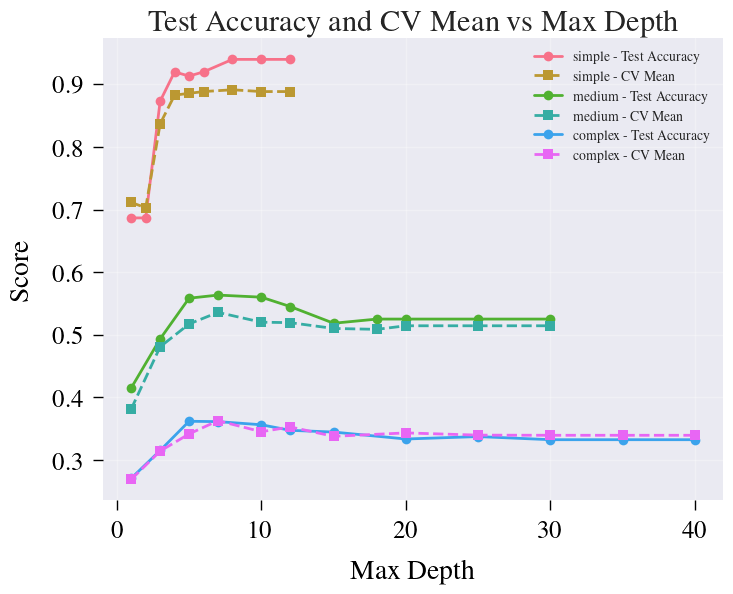

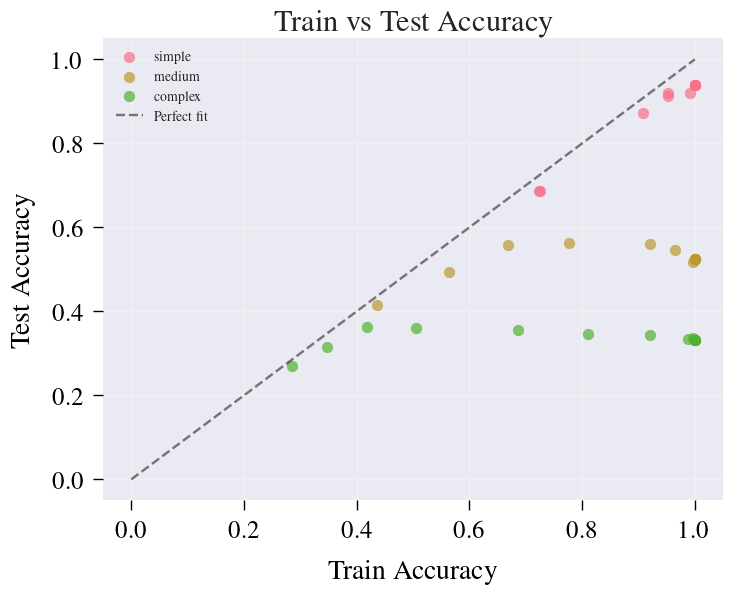

Test Accuracy Summary by Max Depth:


,Dataset,Max Depth,Mean Test Accuracy,Std Test Accuracy
0,simple,1,0.686667,0.0000
1,simple,2,0.686667,0.0000
2,simple,3,0.873333,0.0000
3,simple,4,0.920000,0.0000
4,simple,5,0.913333,0.0000
5,simple,6,0.920000,0.0000
6,simple,8,0.940000,0.0000
7,simple,10,0.940000,0.0000
8,simple,12,0.940000,0.0000
9,simple,None,0.940000,0.0000


In [26]:
print("\n1. Tree Depth Analysis Visualization:")
visualizer.plot_depth_analysis()

In [27]:
# ...existing code...
print("\nPrediction identity beyond last binding depth:")
for ds, rows in analyzer.results['tree_depth'].items():
    # find last index where max_depth is binding
    bound_flags = []
    for r in rows:
        d_spec, d_eff = r['max_depth'], r['mean_depth']
        bound_flags.append((d_spec is not None) and (d_eff >= d_spec - 1e-9))
    if not any(bound_flags):
        print(f"{ds}: no binding depths found")
        continue
    last_bound_idx = max(i for i, b in enumerate(bound_flags) if b)
    base_model = rows[last_bound_idx]['model']
    X_test = dataset_manager.splits[ds]['X_test']
    base_pred = base_model.predict(X_test)

    all_identical = True
    for i in range(last_bound_idx + 1, len(rows)):
        mdl = rows[i]['model']
        pred = mdl.predict(X_test)
        mismatches = int(np.sum(pred != base_pred))
        all_identical &= (mismatches == 0)
        print(f"{ds.upper()}: compare depth={rows[last_bound_idx]['max_depth']} vs {rows[i]['max_depth']}: "
              f"mismatches={mismatches}")
    if last_bound_idx + 1 >= len(rows):
        print(f"{ds.upper()}: no depths beyond last binding to compare")
    elif all_identical:
        print(f"{ds.upper()}: predictions identical for all depths beyond last binding")
# ...existing code...


Prediction identity beyond last binding depth:
SIMPLE: compare depth=8 vs 10: mismatches=0
SIMPLE: compare depth=8 vs 12: mismatches=0
SIMPLE: compare depth=8 vs None: mismatches=0
SIMPLE: predictions identical for all depths beyond last binding
MEDIUM: compare depth=15 vs 18: mismatches=61
MEDIUM: compare depth=15 vs 20: mismatches=61
MEDIUM: compare depth=15 vs 25: mismatches=61
MEDIUM: compare depth=15 vs 30: mismatches=61
MEDIUM: compare depth=15 vs None: mismatches=61
COMPLEX: compare depth=25 vs 30: mismatches=207
COMPLEX: compare depth=25 vs 35: mismatches=207
COMPLEX: compare depth=25 vs 40: mismatches=207
COMPLEX: compare depth=25 vs None: mismatches=207


## Section 4: Experiment 2 - Feature Selection Analysis

**Objective**: Explore the impact of the number of randomly selected features for splits

**Fixed Parameters**: 
- Number of trees (n_estimators)
- Tree depth (use optimal from Experiment 1, or None)
- Bootstrap sampling

**Variable Parameter**: max_features (from 1 feature to all features)

**Expected Observations**:
- Few features: Higher variance between trees, better ensemble diversity
- Many features: Lower variance between trees, potential overfitting
- Optimal features: Balance between diversity and individual tree performance

In [ ]:
# Experiment 2: Feature Selection Analysis
print("="*60)
print("EXPERIMENT 2: FEATURE SELECTION ANALYSIS")
print("="*60)

# Run experiment across all datasets
feature_results = analyzer.experiment_feature_selection(
    dataset_manager.splits,
    verbose=True
)

print("\n" + "="*60)
print("EXPERIMENT 2 COMPLETED")
print("="*60)

EXPERIMENT 2: FEATURE SELECTION ANALYSIS

Analyzing feature selection impact on simple dataset...
Total features: 10, Testing: [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45]
  Features  1: Train=1.000, Test=0.953, CV=0.946+/-0.025
  Features  2: Train=1.000, Test=0.960, CV=0.954+/-0.028
  Features  3: Train=1.000, Test=0.960, CV=0.951+/-0.023
  Features  5: Train=1.000, Test=0.960, CV=0.954+/-0.037
  Features  7: Train=1.000, Test=0.967, CV=0.940+/-0.019
  Features 10: Train=1.000, Test=0.960, CV=0.934+/-0.025

Analyzing feature selection impact on medium dataset...
Total features: 25, Testing: [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45]
  Features  1: Train=1.000, Test=0.670, CV=0.641+/-0.012
  Features  2: Train=1.000, Test=0.687, CV=0.679+/-0.020
  Features  3: Train=1.000, Test=0.672, CV=0.680+/-0.018
  Features  5: Train=1.000, Test=0.680, CV=0.672+/-0.017
  Features  7: Train=1.000, Test=0.673, CV=0.686+/-0.005
  Features 10: Train=1.000, Test=0.667, CV=0.663+/-0.017
  Featu

In [57]:
print("\n2. Feature Selection Analysis Visualization:")
visualizer.plot_feature_analysis()


2. Feature Selection Analysis Visualization:
No feature selection results found. Run experiment first.


## Section 5: Experiment 3 - Interaction Analysis of tree depth and number of trees

**Objective**: Explore the combined impact of tree depth AND number of trees

**Variable Parameters**: max_depth AND max_features (grid search)

**Expected Observations**:
- I expect that the number of trees will matter up until a point, where it will stagnate in performance.
- The number of trees will be influenced by the depth of the trees

In [66]:
# Experiment 3: Feature Selection Analysis
print("="*60)
print("EXPERIMENT 3: FEATURE SELECTION ANALYSIS")
print("="*60)

# Run experiment across all datasets
tree_depth_vs_num_trees = analyzer.experiment_tree_depth_vs_num_trees(
    dataset_manager.splits,
    verbose=True
)

print("\n" + "="*60)
print("EXPERIMENT 3 COMPLETED")
print("="*60)

EXPERIMENT 3: FEATURE SELECTION ANALYSIS

Analyzing tree depth impact on simple dataset...
  Depth         1, Estimators: 1: Train=0.924, Test=0.927, CV=0.920+/-0.021
  Depth         1, Estimators: 3: Train=0.997, Test=0.993, CV=0.997+/-0.003
  Depth         1, Estimators: 5: Train=0.983, Test=0.990, CV=0.980+/-0.009
  Depth         1, Estimators: 7: Train=0.984, Test=0.990, CV=0.986+/-0.008
  Depth         1, Estimators: 9: Train=0.966, Test=0.960, CV=0.961+/-0.017
  Depth         1, Estimators: 11: Train=0.961, Test=0.960, CV=0.960+/-0.017
  Depth         1, Estimators: 13: Train=0.963, Test=0.960, CV=0.961+/-0.017
  Depth         1, Estimators: 15: Train=0.963, Test=0.960, CV=0.961+/-0.017
  Depth         1, Estimators: 17: Train=0.969, Test=0.960, CV=0.964+/-0.018
  Depth         1, Estimators: 19: Train=0.973, Test=0.963, CV=0.971+/-0.012
  Depth         2, Estimators: 1: Train=0.959, Test=0.963, CV=0.957+/-0.015
  Depth         2, Estimators: 3: Train=0.997, Test=0.993, CV=0.997+


3. Tree Depth vs Number of Trees Heatmaps Visualization:


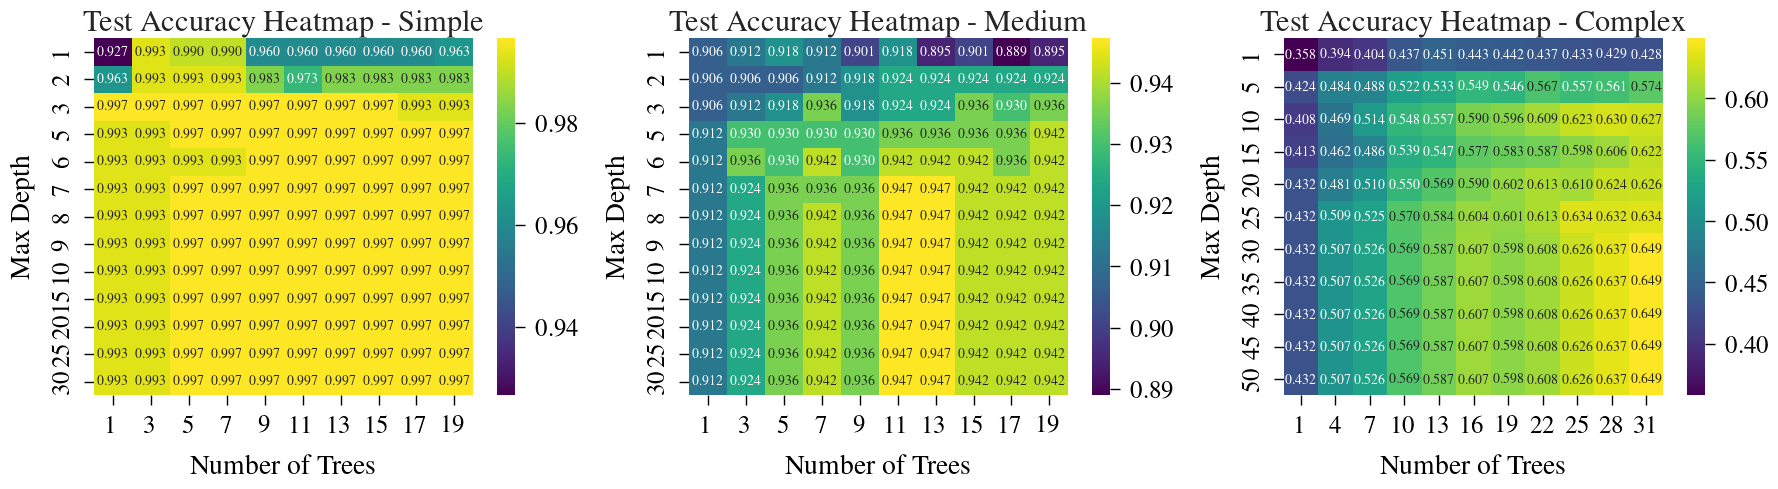

In [67]:
print("\n3. Tree Depth vs Number of Trees Heatmaps Visualization:")
visualizer.plot_tree_depth_vs_num_trees_heatmaps()

In [68]:
optimal_estimators = {'complex': 100, 'medium': 50, 'simple': 10}  

## Section 6: Experiment 4 - Interaction Analysis

**Objective**: Explore the combined impact of tree depth AND feature selection

**Fixed Parameters**: 
- Number of trees (n_estimators)
- Bootstrap sampling

**Variable Parameters**: max_depth AND max_features (grid search)

**Expected Observations**:
- Complex interactions between depth and feature selection
- Different optimal combinations for different dataset complexities
- Potential synergistic or antagonistic effects

In [47]:
# Experiment 4: Interaction Analysis
print("="*60)
print("EXPERIMENT 4: DEPTH x FEATURES INTERACTION ANALYSIS")
print("="*60)


# Run interaction experiment
interaction_results = analyzer.experiment_ensemble_of_forests(
    dataset_manager.splits,
    optimal_estimators=optimal_estimators,
    verbose=True
)

print("\n" + "="*60)
print("EXPERIMENT 4 COMPLETED")
print("="*60)

EXPERIMENT 4: DEPTH x FEATURES INTERACTION ANALYSIS

Ensemble of forests analysis on simple dataset...
     Underfit Ensemble: Train=0.997, Test=0.993, Overfit=0.004
        Mixed Ensemble: Train=0.997, Test=0.997, Overfit=0.000
      Overfit Ensemble: Train=1.000, Test=0.997, Overfit=0.003
      Extreme Contrast: Train=0.997, Test=0.993, Overfit=0.004

Ensemble of forests analysis on medium dataset...
     Underfit Ensemble: Train=0.980, Test=0.930, Overfit=0.050
        Mixed Ensemble: Train=0.997, Test=0.936, Overfit=0.062
      Overfit Ensemble: Train=0.997, Test=0.942, Overfit=0.056
      Extreme Contrast: Train=0.992, Test=0.936, Overfit=0.057

Ensemble of forests analysis on complex dataset...
     Underfit Ensemble: Train=0.614, Test=0.532, Overfit=0.082
        Mixed Ensemble: Train=1.000, Test=0.648, Overfit=0.352
      Overfit Ensemble: Train=1.000, Test=0.635, Overfit=0.365
      Extreme Contrast: Train=1.000, Test=0.645, Overfit=0.355

EXPERIMENT 4 COMPLETED



4. Ensemble of Forests Analysis Visualization:


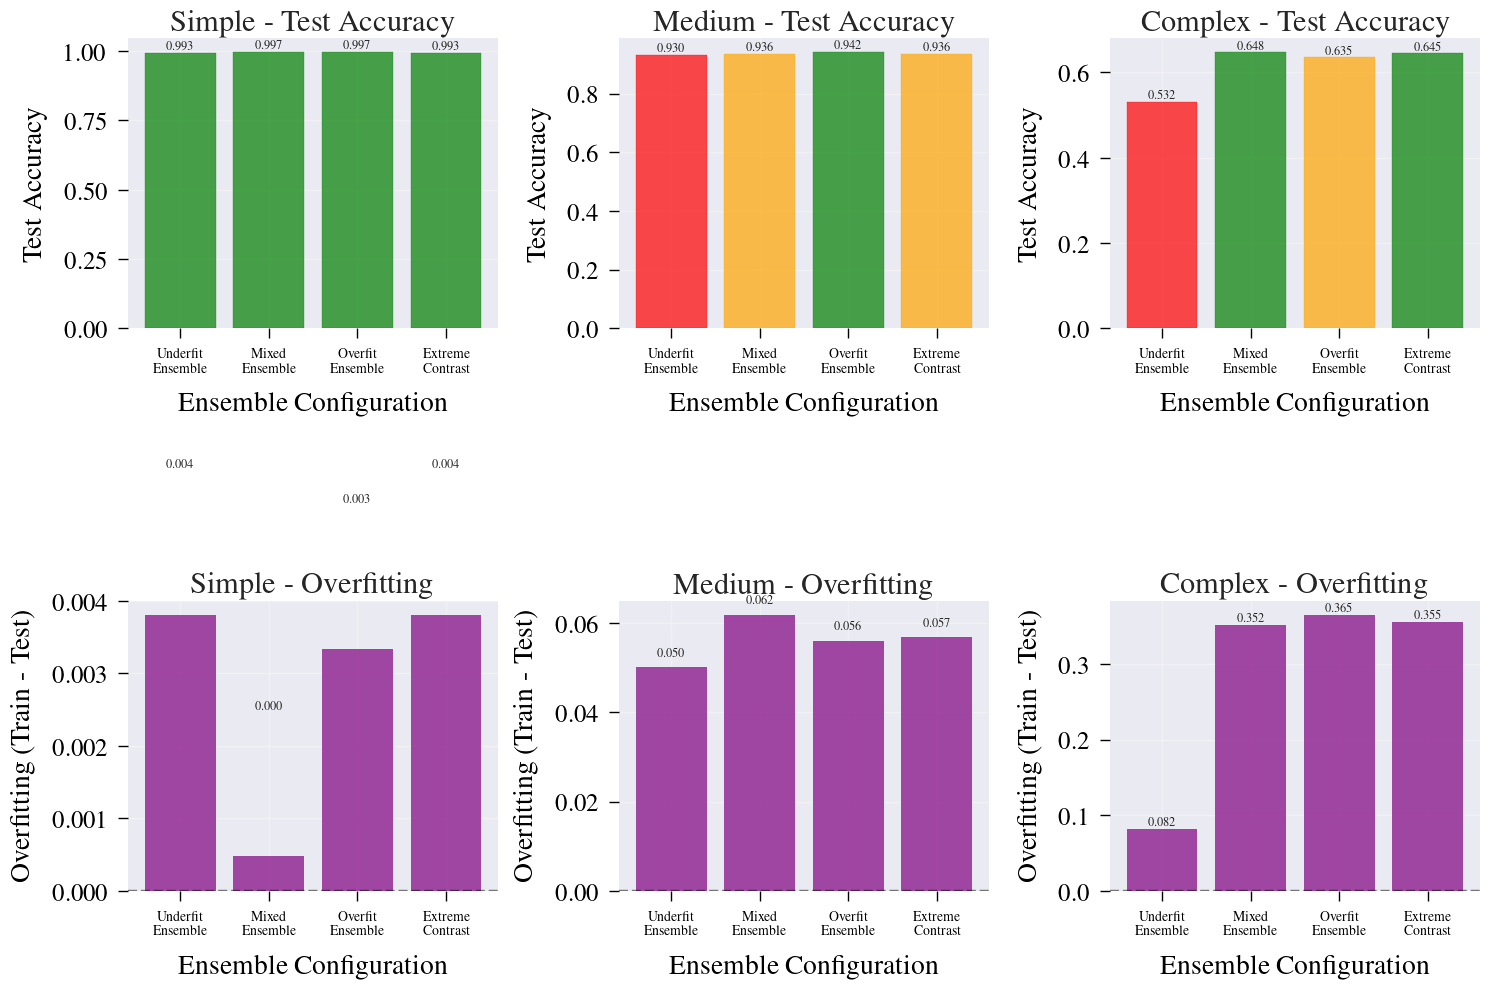


ENSEMBLE OF FORESTS DETAILED ANALYSIS

SIMPLE DATASET:
--------------------------------------------------
Best Configuration: Mixed Ensemble
  Test Accuracy: 0.9967
  Overfitting: 0.0005
  Forest Composition:
    - Depth 1: 20 trees, weight 0.5
    - Depth 5: 30 trees, weight 1.0
    - Depth 15: 30 trees, weight 1.0
    - Depth ∞: 20 trees, weight 0.5

Worst Configuration: Underfit Ensemble
  Test Accuracy: 0.9933
  Overfitting: 0.0038

Individual Forest Performance (Best Config):
  Forest 1 (Depth 1): Train=0.970, Test=0.960, Weight=0.5
  Forest 2 (Depth 5): Train=0.997, Test=0.997, Weight=1.0
  Forest 3 (Depth 15): Train=1.000, Test=0.997, Weight=1.0
  Forest 4 (Depth ∞): Train=1.000, Test=0.997, Weight=0.5

MEDIUM DATASET:
--------------------------------------------------
Best Configuration: Overfit Ensemble
  Test Accuracy: 0.9415
  Overfitting: 0.0560
  Forest Composition:
    - Depth 15: 25 trees, weight 1.0
    - Depth 25: 25 trees, weight 1.0
    - Depth 35: 25 trees, weight 

In [48]:
print("\n4. Ensemble of Forests Analysis Visualization:")
visualizer.plot_ensemble_of_forests_analysis()